# Finding the completeness limit of the observed data

In [1]:
# General imports
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Import observed data as a .csv
observed_df_raw = pd.read_csv('C:/Users/smick/Desktop/Research/data/NGC6569_gaia_withRVs.csv')
observed_df_raw = observed_df_raw.dropna(subset=['pmra', 'pmdec', 'parallax']) # we only want stars with observed motions and parallax

In [3]:
# Correct for extinction by subtracting away the extinction estimate for each star
observed_df_raw['imag_extcorr'] = observed_df_raw['imag'] - observed_df_raw['Ai']


# Calculate average extinction in 'i' band
avg_ext_i = np.mean(observed_df_raw['Ai'])

Due to current limitations in optical resolution, and some good ole' physics, we aren't able to resolve dimmer stars as well as we can brighter stars. That means once we pass a certain magnitude threshold, we are no longer seeing every star in the sky. That threshold is our completeness limit, which we'll find below.

Plot a series of logarithmic histograms in the selected band, and progressively shrink the range down so we can see where the histogram begins leveling off and eventually decreasing.

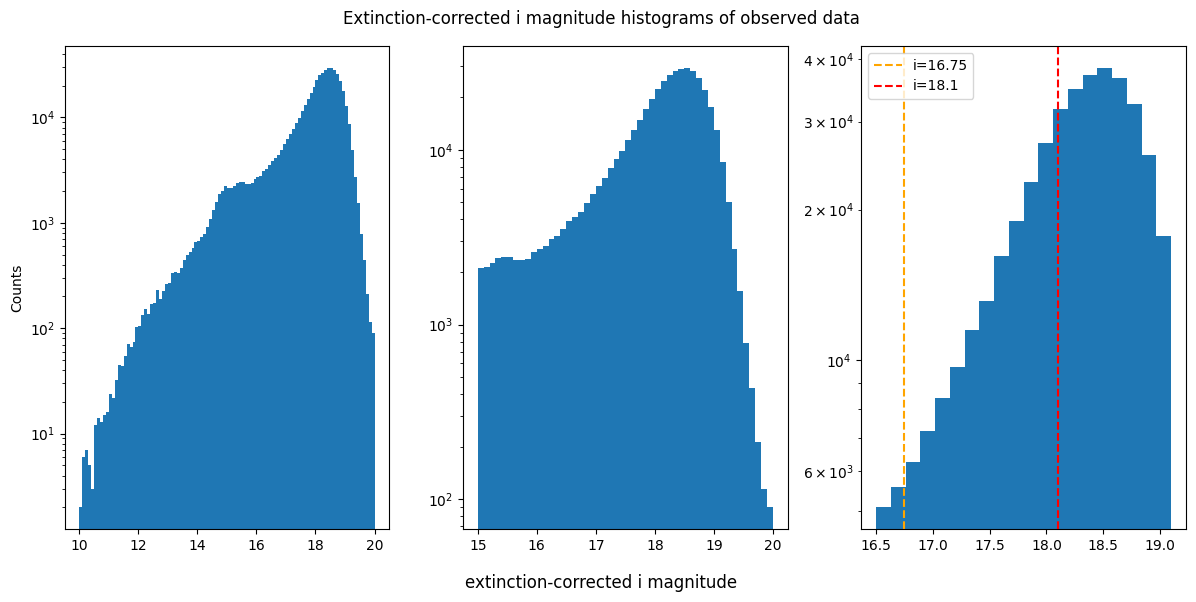

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs.ravel()
fig.suptitle('Extinction-corrected i magnitude histograms of observed data')

# First take a look at the whole range of magnitude values
full_hist = axs[0].hist(observed_df_raw['imag_extcorr'], range=(10, 20), bins=100)
axs[0].set_ylabel('Counts')
axs[0].set_yscale('log')

# Enhance (zoom in)
zoom1_hist = axs[1].hist(observed_df_raw['imag_extcorr'], range=(15, 20), bins=50)
axs[1].set_yscale('log')

# Enhance again
zoom2_hist = axs[2].hist(observed_df_raw['imag_extcorr'], range=(16.5, 19.1), bins=20)
axs[2].set_yscale('log')

# Visualize where the slope is constant
axs[2].axvline(16.75, color='orange', linestyle='dashed', label='i=16.75')
axs[2].axvline(18.1, color='red', linestyle='dashed', label='i=18.1')
axs[2].legend()

fig.supxlabel('extinction-corrected i magnitude')
plt.tight_layout(rect=[-0.005, -0.005, 1, 1])
plt.show()

Using the histograms above to see where we have a constant slope, and where we start losing stars, create a new histogram for the portion of the magnitude range that shows a constant slope. Try to make the range as close to where we start losing stars as possible, that'll be our completeness limit.

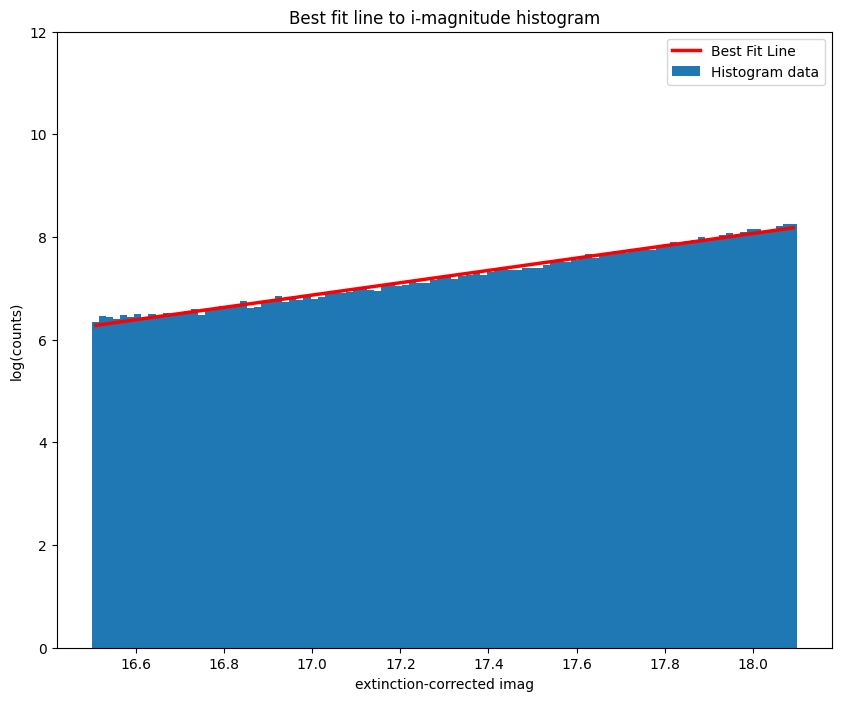

In [71]:
# Make a histogram for just the values that have a constant slope in the plots above
slope_hist = np.histogram(observed_df_raw['imag_extcorr'], range=(16.5,18.1), bins=100) 

# Pull edges and counts from histogram data
counts = slope_hist[0]
edges = slope_hist[1]

# Initialize list for bin centers
centers = list()

# Take logarithm of bin counts
log_counts=np.log(counts)

# Calculate bin centers using the edges
for i in range(len(log_counts)):
    center = (edges[i]+ edges[i+1]) / 2
    centers.append(center)

# Convert bin centers to array for plotting
centers = np.array(centers)

# Calculate the coefficients of the best fit line
coefficients = np.polyfit(centers,log_counts,1) # 1 specifies degree of polynomial

# Evaluates polynomial at center values to create best fit line
fit_line = np.polyval(coefficients, centers)

# Plot the best fit line and make sure it fits the counts
fig,ax =plt.subplots(figsize=(10,8))
plt.title('Best fit line to i-magnitude histogram')
plt.bar(centers, log_counts, width=(edges[1] - edges[0]), label='Histogram data')
plt.plot(centers, fit_line, label='Best Fit Line', color='red', linewidth=2.5)
plt.ylabel('log(counts)')
plt.ylim(0,12)
plt.xlabel('extinction-corrected imag')
plt.legend()
plt.show()

We'll extend this best fit line out to the faintest magnitudes to see where we start losing stars.

C:\Users\smick\AppData\Local\Temp\ipykernel_69304\2965717409.py:12: RuntimeWarning: divide by zero encountered in log
  log_faint_counts=np.log(faint_counts)


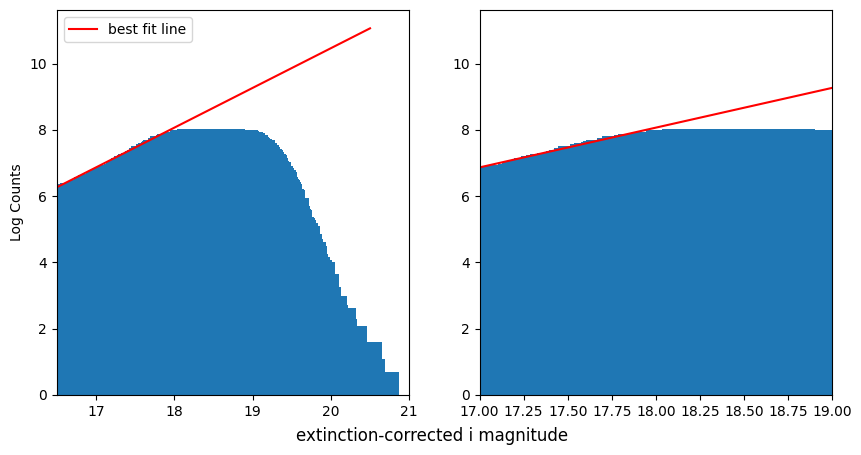

In [104]:
# Create a new histogram for faint magnitudes. Ensure the bins are adjusted to match the new range.
faint_hist = np.histogram(observed_df_raw['imag_extcorr'], range =(16.5,20.5), bins=400)

# Pull counts and edges
faint_counts = faint_hist[0]
faint_edges = faint_hist[1]

# Initialize list
faint_centers = list()

# Take log of counts
log_faint_counts=np.log(faint_counts)

# Calculate bin centers
for i in range(len(log_faint_counts)):
    full_center = (faint_edges[i]+ faint_edges[i+1]) / 2
    faint_centers.append(full_center)

# Convert to array
faint_centers=np.array(faint_centers)

# Pull slope and intercept from polyfit function
slope = coefficients[0]    
intercept = coefficients[1]

# Create a range of magnitudes to extrapolate our best fit line to 
extrapolated_magnitudes = np.linspace(16.5, 20.5, 400)  

# Calculate the extrapolated best fit line in log space
extrapolated_log_counts = slope * extrapolated_magnitudes + intercept

# Plot the full set of i-mag values and extrapolated best fit line
fig,axs = plt.subplots(1,2, figsize=(10,5))
axs[0].bar(faint_centers, log_faint_counts)
axs[0].plot(extrapolated_magnitudes, extrapolated_log_counts, label='best fit line', color='red')
axs[0].set_xlim(16.5,21)
axs[0].set_ylabel('Log Counts')
axs[0].legend()

# Plot it again, but zoom in to where it looks like it deviates
axs[1].bar(faint_centers, log_faint_counts)
axs[1].plot(extrapolated_magnitudes, extrapolated_log_counts, label='Best fit line', color='red') 
axs[1].set_xlim(17,19)

fig.supxlabel('extinction-corrected i magnitude')
plt.show()

We can now take this best fit line, and subtract away the count value for each magnitude. Once the difference reaches 10% between what we expect and what we actually see, we'll call that the completeness limit.

The earliest magnitude with a 10% decrease in stars: 18.634999999999998


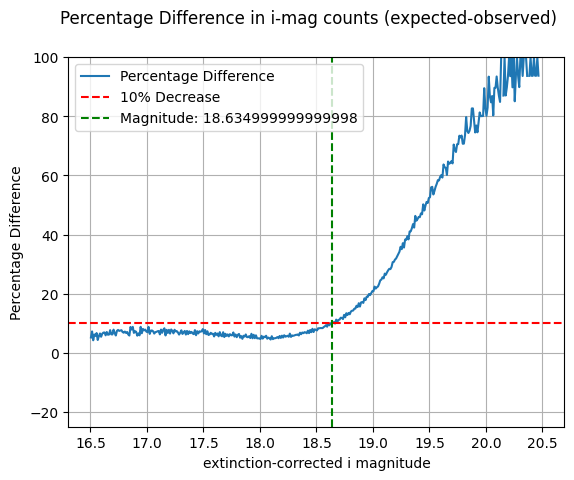

In [108]:
percentage_difference = 100 * (extrapolated_log_counts - log_faint_counts) / extrapolated_log_counts

# Find the earliest magnitude where the observed count is at least 10% less than the extrapolated count
magnitude_with_10_percent_decrease = None
for i, perc_diff in enumerate(percentage_difference):
    # if we see a 10% or greater increase, replace None with the center value of that bin
    if perc_diff >= 10:
        magnitude_with_10_percent_decrease = faint_centers[i]
        break
print(f"The earliest magnitude with a 10% decrease in stars: {magnitude_with_10_percent_decrease}")

# Plot the percentage difference
plt.plot(faint_centers, percentage_difference, label='Percentage Difference')
plt.suptitle('Percentage Difference in i-mag counts (expected-observed)')
plt.axhline(10, color='red', linestyle='--', label='10% Decrease')
plt.axvline(magnitude_with_10_percent_decrease, color='green', linestyle='--', label=f'Magnitude: {magnitude_with_10_percent_decrease}')
plt.xlabel('extinction-corrected i magnitude')
plt.ylabel('Percentage Difference')
plt.ylim(-25,100)
plt.grid()
plt.legend()
plt.show()